100%|██████████| 18/18 [11:12<00:00, 37.38s/it]


Test Accuracy (SVM): 69.57%
Classification Report (SVM):
                 precision    recall  f1-score   support

      Positive       0.57      0.23      0.33       101
      Negative       0.63      0.47      0.54       495
  Not_relevant       0.78      0.79      0.79      1279
Mixed Feelings       0.65      0.79      0.72      1297
       Neutral       0.67      0.53      0.59       587

      accuracy                           0.70      3759
     macro avg       0.66      0.56      0.59      3759
  weighted avg       0.69      0.70      0.69      3759



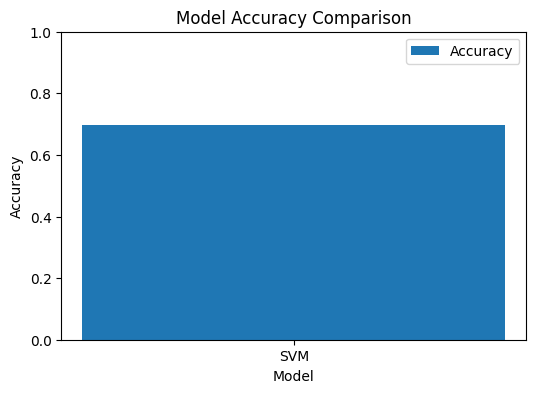

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data from CSV
file_path = 'final_manglish_transliterated.csv'
data = pd.read_csv(file_path)

# Ensure 'transliterated_text' column contains strings
data['transliterated_text'] = data['transliterated_text'].astype(str)

# Define sentiment labels
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

# Map sentiment labels to numerical values
data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and sequence padding
max_words = 1000
vectorizer = CountVectorizer(max_features=max_words)
X = vectorizer.fit_transform(data['transliterated_text'])
y = data['Sentiment_Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Instantiate SVM classifier
svm_model = SVC(random_state=42)

# Define a simplified parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Create a progress bar for grid search
pbar = tqdm(total=len(param_grid['C']) * len(param_grid['gamma']) * len(param_grid['kernel']))

# Perform GridSearchCV with progress bar
best_score = -1
best_params = None
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            svm_model.set_params(C=C, gamma=gamma, kernel=kernel)
            svm_model.fit(X_train, y_train)
            y_pred = svm_model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
            pbar.update(1)

pbar.close()

# Use the best model from grid search
best_svm_model = SVC(**best_params, random_state=42)
best_svm_model.fit(X_train, y_train)

# Evaluate the best SVM model on test data
y_pred_svm = best_svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Generate predictions for SVM
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]
y_pred_labels_svm = [reverse_sentiment_dict[label] for label in y_pred_svm]

# Print complete classification report for SVM
print("Classification Report (SVM):\n", classification_report(y_test_labels, y_pred_labels_svm, target_names=sentiment_dict.keys()))

# Plotting the accuracy comparison (SVM only)
plt.figure(figsize=(6, 4))
plt.bar(['SVM'], [accuracy_svm], width=0.4, label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.legend()
plt.show()


Test Accuracy (SVM): 79.64%
Classification Report (SVM):
                 precision    recall  f1-score   support

      Positive       0.94      0.96      0.95      1218
      Negative       0.80      0.75      0.78      1257
  Not_relevant       0.78      0.77      0.78      1312
Mixed Feelings       0.68      0.70      0.69      1238
       Neutral       0.78      0.80      0.79      1262

      accuracy                           0.80      6287
     macro avg       0.80      0.80      0.80      6287
  weighted avg       0.80      0.80      0.80      6287



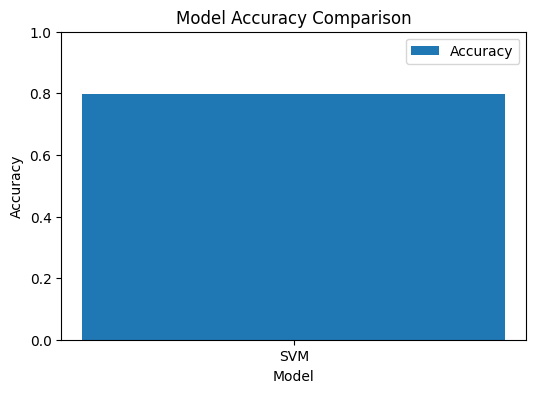

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load data from CSV
file_path = 'final_manglish_transliterated.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['transliterated_text'] = data['transliterated_text'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and sequence padding
max_words = 1000
max_seq_length = 100
vectorizer = CountVectorizer(max_features=max_words)
X = vectorizer.fit_transform(data['transliterated_text'])
y = data['Sentiment_Class']

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and sequence padding for balanced data
X_upsampled = vectorizer.fit_transform(data_upsampled['transliterated_text'])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=10)

# Build and train SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Using a linear kernel, you can also try other kernels like 'rbf'
svm_model.fit(X_train, y_train)

# Evaluate the SVM model on test data
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (SVM): {accuracy_svm * 100:.2f}%")

# Generate predictions for SVM
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]
y_pred_labels_svm = [reverse_sentiment_dict[label] for label in y_pred_svm]

# Print complete classification report for SVM
print("Classification Report (SVM):\n", classification_report(y_test_labels, y_pred_labels_svm, target_names=sentiment_dict.keys()))

# Plotting the accuracy comparison (SVM only)
plt.figure(figsize=(6, 4))
plt.bar(['SVM'], [accuracy_svm], width=0.4, label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.legend()
plt.show()
